# **Contributions**

Ryan : DQN (Model 1) \
Melvin : Q-learning (Model 2) \
Vivian : Research on DDQN + Detailed annotations + Extracted model into file


# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install torch.nn
!pip install torch.optim

^C
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/u

## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.00935208  0.04874972 -0.00991341  0.00790529]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)
print("Info", info)

New observations after choosing action 0: [-0.00837709 -0.14622867 -0.0097553   0.297444  ]
Reward for this step: 1.0
Is this round done? False
Info {}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [ ]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.03873248 -0.0393616   0.00654844 -0.02177495]
Chosen action: 0


 Replay Memory

In [ ]:
from collections import namedtuple, deque
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#Model 1: Deep-Q Network

We will attempt to train a Deep Q-Network agent which is aimed at learning the optimal action-selection policy specific to the cartpole environment. \
\
The DQN agent employs a deep neural network to repeatedly approximate Q-value function, which gives the expected cumulative rewards when a particular action is taken at a specific state. \
\
DQNs consist of both policy and target networks that serve different purposes. The policy network takes the state of the environment as input and returns Q-values for each possible actions. While the target network is similarly used to generate target Q-values, its' fixed parameters help to stabilize the training process. The policy network is updated to minimize the error between predicted Q-values and target Q-values.

## Task 1 (DQN): Development of an RL agent

Code was adadpted from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class DQN(nn.Module):

    # Setting up of neural network with 2 hidden layers with 16 nodes each
    # Reference sample constructed neural network with 128 nodes in each of the 2 hidden layers
    # However, due to limited number of observations (input variables), we reduced number of nodes
    # to prevent overtraining and limit complexity of neural network to reduce computation time
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Create fully connected layers
        self.layer1 = nn.Linear(n_observations, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, n_actions)

    # Function to determine the expected return of taking each action given the current input
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# Define hyperparameters
BATCH_SIZE = 500 # No. of training examples for one iteration of training
# Due to the highly volatile nature of our original training results, we decided to increase the batch size to allow our model to capitalize on relatively high previously achieved results.
GAMMA = 0.99 # Discount factor
EPS_START = 0.9 # Initial exploration rate
EPS_END = 0.05 # Final exploration rate
EPS_DECAY = 1000 # Rate of exponential decay of epsilon
TAU = 0.005 # Update rate of target network
LR = 0.0015 # Learning rate of optimizer
# We observed the model taking a huge number of episodes to start showing results, hence significantly increased learning rate to improve efficiency.

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Setting up of policy and target neural networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device) # Same architecture as policy network but with fixed parameters
# The target network is used to stabilize training by providing target Q-values during the learning process.
target_net.load_state_dict(policy_net.state_dict())
# Initializes the target network with the same initial parameters as the policy network
# Facilitates starting training with a stable set of parameters in both networks.

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# initializes an AdamW optimizer for the policy_net, along with its parameters (from policy net), learning rate (declared above), and using the AMSGrad variant for optimization during training.
memory = ReplayMemory(10000) # Experience replay - stores past interactions with environment and the outcomes of actions

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    # Epsilon-greedy strategy : Explore more initially then shift to exploitation (choose actions based on learned values)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold: # Exploitation
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # Second column on max result is index of where max element was
            # Found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # Exploration : trying new actions
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

In [ ]:
# Training function
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # A final state would've been the one after which simulation ended
    # Filter out final states from batch
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    # Concatenate into tensors for efficient computation
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q-values for state-actions pairs using policy network
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Initialise expected next_state_values
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Compute expected values of the next states using target network
        # max(1).values selects the highest reward
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss between calculated and expected Q-values
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward() # Backpropagation
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100) # In-place gradient clipping to prevent large gradients
    optimizer.step() # Update parameters of policy network to reduce loss

In [ ]:
# Function to save and load model
def save_model(model, filename="DQN_policy_net.pth"):
  torch.save(model.state_dict(), filename)

In [ ]:
# Main training loop
from itertools import count
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

num_episodes = 2000
# To give model enough episodes to reach an acceptable standard
episode_results = []
# Initialize array for real-time analysing and plotting of results

for i_episode in range(num_episodes):
    # Initialize the environment and get its initial state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_steps = 0
    for t in count():
        action = select_action(state) # Epsilon-greedy policy based on current state
        observation, reward, done,_ = env.step(action.item()) # Execute action in environment
        reward = torch.tensor([reward], device=device)
        total_steps+=1
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Progress to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # Recording steps achieved every episode
            episode_results.append(total_steps)
            print("episode" + str(i_episode) + " || total steps: "+str(total_steps))
            break

    # Early Stopping when average score of last 3 episodes exceeds 400
    # This prevents overfitting by stopping training before the agent starts to memorize training data
    if i_episode>10 and (episode_results[i_episode] + episode_results[i_episode-1] + episode_results[i_episode-2]) / 3 > 400:
      save_model(policy_net)
      break



episode0 || total steps: 26
episode1 || total steps: 15
episode2 || total steps: 41
episode3 || total steps: 10
episode4 || total steps: 32
episode5 || total steps: 21
episode6 || total steps: 24
episode7 || total steps: 11
episode8 || total steps: 41
episode9 || total steps: 33
episode10 || total steps: 16
episode11 || total steps: 16
episode12 || total steps: 8
episode13 || total steps: 10
episode14 || total steps: 26
episode15 || total steps: 14
episode16 || total steps: 10
episode17 || total steps: 12
episode18 || total steps: 12
episode19 || total steps: 20
episode20 || total steps: 10
episode21 || total steps: 10
episode22 || total steps: 10
episode23 || total steps: 17
episode24 || total steps: 12
episode25 || total steps: 12
episode26 || total steps: 25
episode27 || total steps: 20
episode28 || total steps: 16
episode29 || total steps: 14
episode30 || total steps: 15
episode31 || total steps: 11
episode32 || total steps: 11
episode33 || total steps: 10
episode34 || total steps:

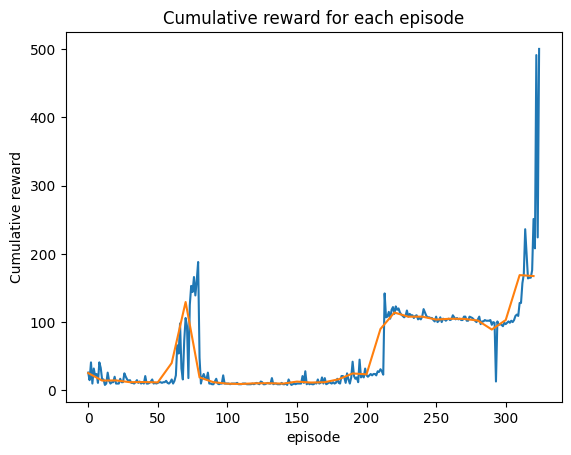

In [ ]:
# Illustrate training progress
plt.plot(episode_results) # Blue
# Include mean cumulative reward for every 10 consecutive episodes
means = [sum(episode_results[i:i+10]) / 10 for i in range(0, len(episode_results), 10)]
x_values = [i*10 for i in range(len(means))]
plt.plot(x_values, means) # Yellow
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

## Task 2 (DQN): Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [ ]:
# Load model for demonstration
def load_model(model, filename='DQN_policy_net.pth'):
    model.load_state_dict(torch.load(filename))
    return model

policy_net = DQN(n_observations, n_actions).to(device)

# Load the saved model state
policy_net = load_model(policy_net)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_policy_action(state):
    # Convert the state to a torch tensor and unsqueeze to add batch dimension
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Use the policy network to predict the action values for the given state
    with torch.no_grad():
        action_values = policy_net(state_tensor)

    # Choose the action with the highest predicted value
    action = action_values.argmax().item()

    return action

In [ ]:
num_episodes = 100
episode_results = []
# Runs policy across 100 episodes for demonstration
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    observation = env.reset()
    total_steps = 0

    while True:
        # Calculate action with neural network
        action = get_policy_action(observation)
        total_steps+=1
        # Get observation for next step and done for the event pole falls, reward and info not used
        observation, reward, done, info = env.step(action)
        if done:
            episode_results.append(total_steps)
            print("episode" + str(i_episode) + " || total steps: "+str(total_steps))
            break;



episode0 || total steps: 500
episode1 || total steps: 497
episode2 || total steps: 500
episode3 || total steps: 500
episode4 || total steps: 500
episode5 || total steps: 500
episode6 || total steps: 500
episode7 || total steps: 488
episode8 || total steps: 500
episode9 || total steps: 497
episode10 || total steps: 500
episode11 || total steps: 500
episode12 || total steps: 492
episode13 || total steps: 500
episode14 || total steps: 471
episode15 || total steps: 500
episode16 || total steps: 500
episode17 || total steps: 500
episode18 || total steps: 500
episode19 || total steps: 500
episode20 || total steps: 483
episode21 || total steps: 500
episode22 || total steps: 500
episode23 || total steps: 500
episode24 || total steps: 500
episode25 || total steps: 484
episode26 || total steps: 500
episode27 || total steps: 500
episode28 || total steps: 483
episode29 || total steps: 500
episode30 || total steps: 495
episode31 || total steps: 500
episode32 || total steps: 500
episode33 || total s

In [ ]:
plt.plot(episode_results)
means = [sum(episode_results[i:i+10]) / 10 for i in range(0, len(episode_results), 10)]
x_values = [i*10 for i in range(len(means))]
plt.plot(x_values, means)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [ ]:
# Average Cumulative Reward
print("Average cumulative reward:", sum(episode_results)/len(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Average cumulative reward: 495.8
Is my agent good enough? True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Task 3 (DQN): Render one episode played by the agent

In [ ]:
def get_policy_action(state):
    # Convert the state to a torch tensor and unsqueeze to add batch dimension
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Use the policy network to predict the action values for the given state
    with torch.no_grad():
        action_values = policy_net(state_tensor)

    # Choose the action with the highest predicted value
    action = action_values.argmax().item()

    return action

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    action = get_policy_action(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Model 2 : Q-Learning

Q-learning agent determines an optimal action-value function directly from observations without the need of a model of the environment\
\
We will be calculating the reward differently for this model. The reward is computed based on how center the cartpole is.\
\
We will be adapting code from this library: https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb

## Task 1 (Q-Learning): Development of an RL agent

As Q-learning makes use of discrete states, a continous environment such as cartpole needs to be discretized and expressed as bins of states instead.

We will make use of sklearn's discretizer library for this purpose. Note that we have limited the lower and upper bounds of angular velocity as the observation space is too large to be effeciently discretized and represented in the Q-table.

The number of bins for pole angle is due to the fact that it ranges between (-24, 24) degrees, and hence the choice to have 1 degree per bin.
The number of bins for cart velocity, cart position and pole angular velocity were arbitrary.

In [ ]:
env = gym.make("CartPole-v1")

lower_bounds = [env.observation_space.low[i] for i in range(3)]
upper_bounds = [env.observation_space.high[i] for i in range(3)]
lower_bounds.append(-1.08)
upper_bounds.append(1.08)

# Number of bins to discretize each dimension of the observation space
buckets = (5, 5, 48, 24)
Q_table = np.zeros((5, 5, 48, 24, 2))

from sklearn.preprocessing import KBinsDiscretizer
def discretize_state(obs):
    est = KBinsDiscretizer(n_bins=buckets,
                          encode="ordinal",
                          strategy="uniform",
                          subsample=None)
    est.fit([lower_bounds,upper_bounds])
    discrete_state = tuple(map(int, (est.transform([obs])[0])))
    return discrete_state

As we intend to reward the RL for being more "centered" rather than off-centre given all else constant, we will adjust the internal reward based on weighted observations of the next state.

As such, we assigned an arbitrary weight to each observation with the exception of angular velocity. For the remaining 3 observations, the closer they are to 0, the higher the reward.

For angular velocity itself, the reward is given depending if the agent chose to move in the same direction as the pole's fall.

In [ ]:
def calculate_reward(obs, steps, action):
    def calculate_reward_for_angular_velocity():
        angular_velocity = obs[0][3]
        # Check if action matches the direction of angular velocity (eg. moving left when pole is tilting left)
        # Matches : Chosen action is contributing positively to stabilizing the pole
        if (action==0) and (angular_velocity<0):
            return 1
        elif (action==1) and (angular_velocity>0):
            return 1
        else:
          return -1

    weights = np.array([0.1, 0.1, 0.8, 0])
    observation = np.exp(-1 * abs(obs[0]))
    # Take weighted sum of the transformed observation values
    # Final reward includes reward from angular velocity => captures both current state and stability of agent's actions
    reward = sum(x * y for x, y in zip(weights, observation)) + calculate_reward_for_angular_velocity()
    return reward

Next action ought to have a exponentially decaying chance to be random, which allows the RL to learn. First iteration requires it to be random and hence is set to 1 by default.

Due to the size of the Q-table generated, heavy emphasis was placed on exploration for the RL. This is to ensure the agent explores episodes "deeply" and have higher coverage of the Q-table rather than overly optimizing the earlier stages of an episode.\

get_epsilon() was obtained from: https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb

In [ ]:
min_epsilon = 0.5
min_epi_to_explore = 200

def get_epsilon(episode):
    # Gets value for epsilon which declines as we advance in episodes.
    # Ensures that there is almost at least a min_epsilon chance of randomly exploring
    return max(min_epsilon, min(1., 1. - math.log10((episode + 1) / min_epi_to_explore)))

def choose_action(current_state, episode):
        if (np.random.random() < get_epsilon(episode)):
            return env.action_space.sample() # Exploration, randomly sampling an action
        else:
            return np.argmax(Q_table[current_state]) # Exploitation, select action with highest Q-value for current state

Similarly, the learning rate ought to decay in the same fashion as well.

get_learning_rate() was obtained from: https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb

In [ ]:
min_lr = 0.1 # Minimum threshold

def get_learning_rate(episode):
    # Gets value for learning rate which declines as we advance in episodes.
    # Learning rate also declines as we add more episodes
    return max(min_lr, min(1., 1. - math.log10((episode + 1) / min_epi_to_explore)))

In [ ]:
def update_q_table(learning_rate, new_state, current_state, action, steps, discount=0.99):
    def calculate_new_q():
        current_q = Q_table[current_state][action]
        # Q-learning update rule: Q(s,a)←Q(s,a)+α⋅(r+γ⋅max Q(s′,a′)−Q(s,a))
        new_q = current_q + learning_rate*(reward + discount*np.max(Q_table[new_state]) - current_q)
        return new_q

    obs = env.step(action) # Execute action in environment
    reward = calculate_reward(obs, steps, action)

    Q_table[current_state][action] = calculate_new_q() # Store updated Q-value
    return True

**Q Learning off-policy training**

Structure was adapted from :https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb

In [ ]:
num_episodes = 1000
steps = np.zeros(num_episodes)

# Training function
def train():
    # Looping for each episode
    for e in range(num_episodes):
        # Initializes the state
        current_state = discretize_state(env.reset())
        learning_rate = get_learning_rate(e)
        epsilon = get_epsilon(e)
        done = False
        # Looping for each step
        while not done:
            steps[e] += 1
            # Choose action from currrent state
            action = choose_action(current_state, e)
            # Execute action in environment
            obs, reward, done, _ = env.step(action)
            new_state = discretize_state(obs)
            # Update Q(S,A)
            if not update_q_table(learning_rate, new_state, current_state, action, steps[e]):
                print('Failed to update Q_table')
            current_state = new_state
        if (e+1)%100==0:
          print("Episode", e+1, ", No. of steps:", steps[e])
    print('Finished training!')
train()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100 , No. of steps: 8.0
Episode 200 , No. of steps: 11.0
Episode 300 , No. of steps: 9.0
Episode 400 , No. of steps: 11.0
Episode 500 , No. of steps: 11.0
Episode 600 , No. of steps: 9.0
Episode 700 , No. of steps: 15.0
Episode 800 , No. of steps: 35.0
Episode 900 , No. of steps: 29.0
Episode 1000 , No. of steps: 26.0
Finished training!


episode 1 cul steps 6.0
episode 51 cul steps 19.0


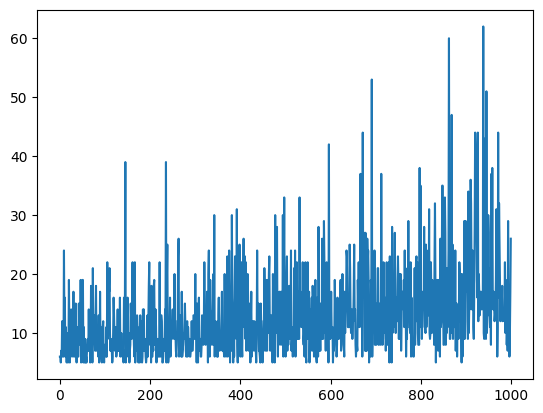

In [ ]:
for i in range(1,100,50):
  print(f"episode {i} cul steps {steps[i]}" )

plt.plot(steps)

## Task 2 (Q-Learning): Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

episode 0 cul steps 500.0
episode 10 cul steps 173.0
episode 20 cul steps 285.0
episode 30 cul steps 306.0
episode 40 cul steps 500.0
episode 50 cul steps 378.0
episode 60 cul steps 500.0
episode 70 cul steps 500.0
episode 80 cul steps 448.0
episode 90 cul steps 478.0
Average cumulative reward: 331.34
Is my agent good enough? True


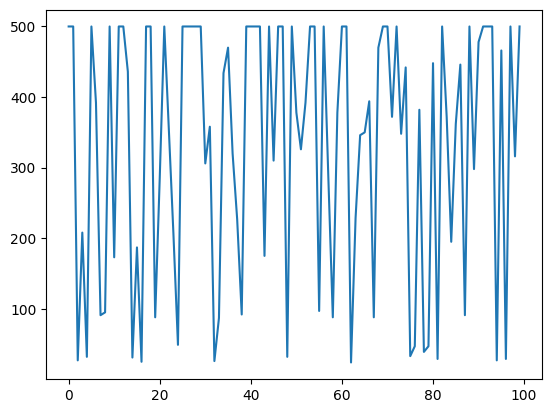

In [ ]:
num_episodes = 100
steps = np.zeros(num_episodes)

for e in range(num_episodes):
    current_state = discretize_state(env.reset())
    done = False
    while not done:
        #Choose optimal action
        action = np.argmax(Q_table[current_state])
        steps[e] += 1
        obs, reward, done, _ = env.step(action)
        new_state = discretize_state(obs)
        #Update state
        current_state = new_state
    if not e%10:
      print(f"episode {e} cul steps {steps[e]}" )

print(f'Average cumulative reward: {sum(steps)/num_episodes}')
print("Is my agent good enough?", np.mean(steps)>195 )
plt.plot(steps)


## Task 3 (Q-Learning): Render one episode played by the agent

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
steps=0

while True:
    env.render()
    action = np.argmax(Q_table[current_state])
    observation, reward, done, _ = env.step(action)

    new_state = discretize_state(observation)
    current_state = new_state

    steps+=1
    if done:
      break;

print(f' steps taken: {steps}')
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


 steps taken: 467


# **Evaluation**

Both agents performed well for testing despite relatively poorer performance for training. This could be attributed to the following reasons: \
1. CartPole has relatively simple dynamics compared to other more sophisticated environments. It has a low-dimensional state-space with deterministic dynamics. Therefore, even with limited exploration during training, the agent may still learn a reasonably good policy which generalizes well to new states.
2. CartPole provides a sparse reward signal. The agent is awarded a reward of +1 for every timestep the pole is balanced and receives no other rewards. The sparse reward signal motivates the agent to focus on the main task of balancing the pole, which may be relatively easier to learn compared to environments with more complex reward signals.
\
\
Thank you!

# **References**
DQN: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Q-learning: \
https://github.com/johnnycode8/gym_solutions/blob/main/cartpole_q.py \
https://github.com/JoeSnow7/Reinforcement-Learning/blob/master/Cartpole%20Q-learning.ipynb